In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import time  # 用于记录时间
from docx import Document
#加载数据和路径并进行预处理
# Load the dataset
file_path = r"C:/Users/13844/Desktop/papers/paper4/data/MSS_modified.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Create sequences for multi-step input and output
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

# Parameters (Modified for weaker performance)
input_steps = 48*8   # Number of historical data points used for prediction  #修改时间步长48*1 2 4 8 16 
output_steps = 12*8  # Number of future data points to predict #修改时间步长12*1 2 4 8 16 

# Create sequences
X, y = create_sequences(normalized_data, input_steps, output_steps)

# Split the data into train, validation, and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


# Output directory for model and results
output_dir = r'C:/Users/13844/Desktop/papers/paper4/results/' + f"LSTM_{input_steps}_{output_steps}" #修改GRU LSTM TCN 
os.makedirs(output_dir, exist_ok=True)

# Define model save path and log file path
model_save_path = os.path.join(output_dir, 'best_model.keras')
log_file_path = os.path.join(output_dir, 'training_log.txt')


In [34]:
#读取模型并用于预测测试集数据
model_save_path = os.path.join(output_dir, 'best_model.keras')
# Load the best model
best_model = load_model(model_save_path)

# Predict on test data using the best model
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values
# 反标准化预测数据和真实数据，并恢复为三维数组
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[2]))
y_pred_rescaled1 = y_pred_rescaled.reshape(y_pred.shape)  # 恢复为三维数组

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2]))
y_test_rescaled1 = y_test_rescaled.reshape(y_test.shape)  # 恢复为三维数组
y_test_rescaled1.shape

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step


(6001, 96, 11)

SMAPE: 3.1425%
Feature: MFBT, MAE: 0.4959, MSE: 0.3133, RMSE: 0.5597, MAPE: 0.8839%, MSPE: 0.0100%, R²: 0.9666
Feature: MRBT, MAE: 0.5654, MSE: 0.4356, RMSE: 0.6600, MAPE: 1.2178%, MSPE: 0.0203%, R²: 0.9510
Feature: CUR, MAE: 3.1670, MSE: 15.0960, RMSE: 3.8854, MAPE: 5.3586%, MSPE: 0.4255%, R²: -0.4523
Feature: OP, MAE: 0.2091, MSE: 0.0670, RMSE: 0.2588, MAPE: 20.7760%, MSPE: 7.2632%, R²: -0.0780
Feature: FSBT, MAE: 0.3580, MSE: 0.1842, RMSE: 0.4291, MAPE: 0.6578%, MSPE: 0.0061%, R²: 0.9450
Feature: VBF, MAE: 3.9515, MSE: 24.1606, RMSE: 4.9153, MAPE: 10.8640%, MSPE: 1.8236%, R²: -0.0204
Feature: RSBT, MAE: 0.2606, MSE: 0.1164, RMSE: 0.3412, MAPE: 0.4617%, MSPE: 0.0036%, R²: 0.9571
Feature: TBT, MAE: 0.2903, MSE: 0.1228, RMSE: 0.3504, MAPE: 0.4938%, MSPE: 0.0035%, R²: 0.9524
Feature: PACT, MAE: 0.5140, MSE: 0.4056, RMSE: 0.6369, MAPE: 0.7382%, MSPE: 0.0083%, R²: 0.9641
Feature: PBCT, MAE: 0.5052, MSE: 0.3872, RMSE: 0.6223, MAPE: 0.7129%, MSPE: 0.0076%, R²: 0.9655
Feature: PCCT, MAE: 0.5

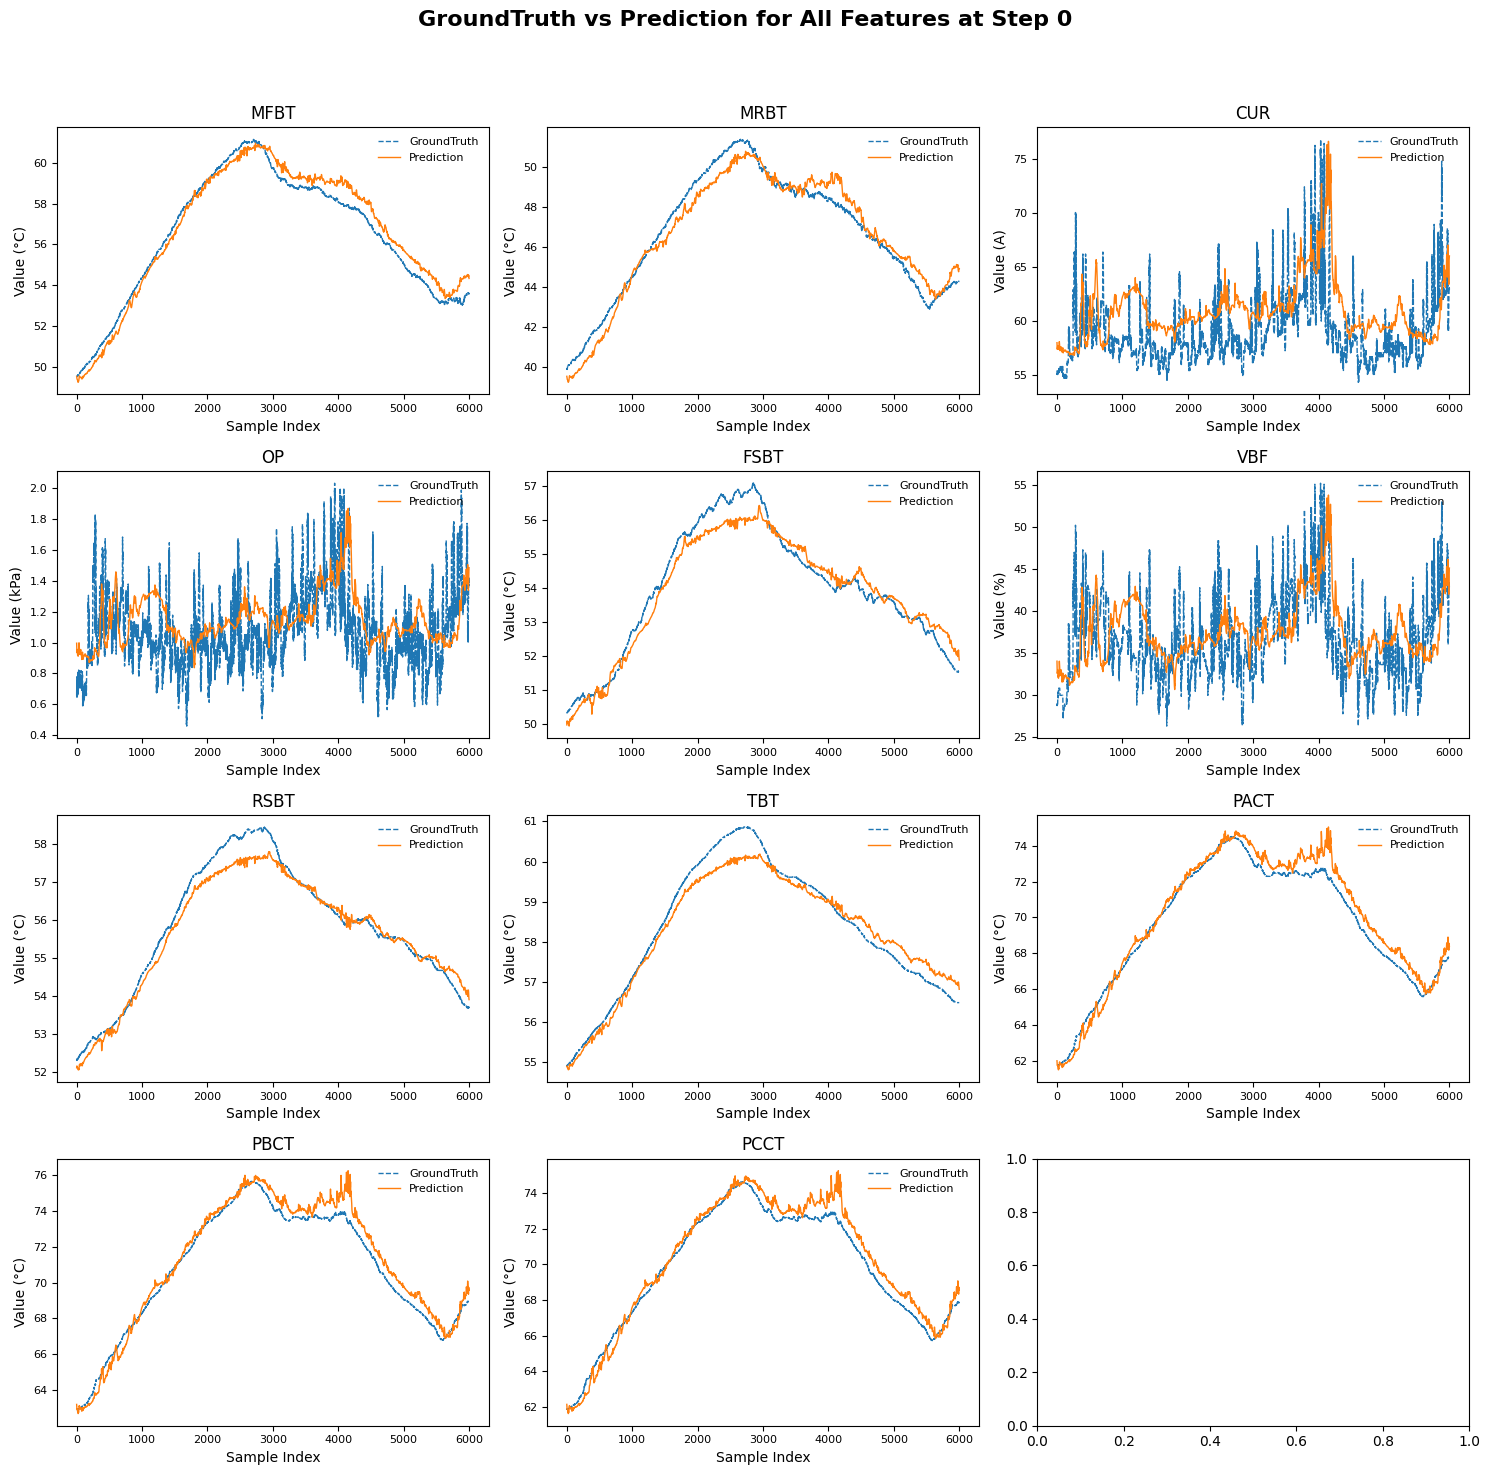

Plot saved at: C:/Users/13844/Desktop/papers/paper4/results/LSTM_384_96\Feature_Step_Comparison.png
GroundTruth data saved at: C:/Users/13844/Desktop/papers/paper4/results/LSTM_384_96\GroundTruth_Data.csv
Prediction data saved at: C:/Users/13844/Desktop/papers/paper4/results/LSTM_384_96\Prediction_Data.csv


In [35]:
#通过数据计算性能指标和绘制结果图并保存指定路径
# Define SMAPE metric
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)) * 100

# Calculate SMAPE
smape_score = smape(y_test_rescaled, y_pred_rescaled)
print(f"SMAPE: {smape_score:.4f}%")

# Feature information
feature_info = [
    ("MFBT", "°C"), ("MRBT", "°C"), ("CUR", "A"), ("OP", "kPa"), ("FSBT", "°C"),
    ("VBF", "%"), ("RSBT", "°C"), ("TBT", "°C"), ("PACT", "°C"), ("PBCT", "°C"), ("PCCT", "°C")
]

# Metrics storage
metrics = []

# Performance metrics and visualization
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle('GroundTruth vs Prediction for All Features at Step 0', fontsize=16, weight='bold')

for feature_idx, (feature_name, unit) in enumerate(feature_info):
    row, col = divmod(feature_idx, cols)
    ax = axes[row, col]

    # Extract true and predicted values for the feature
    true_values = y_test_rescaled1[:, output_steps-1, feature_idx]
    pred_values = y_pred_rescaled1[:, output_steps-1, feature_idx]

    # Plot comparison
    ax.plot(true_values, label='GroundTruth', linestyle='--', linewidth=1)
    ax.plot(pred_values, label='Prediction', linestyle='-', linewidth=1)
    
    ax.set_title(f"{feature_name}", fontsize=12)
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel(f"Value ({unit})", fontsize=10)
    ax.legend(fontsize=8, loc='upper right', frameon=False)
    ax.tick_params(axis='both', labelsize=8)

    # Compute metrics
    mae = np.mean(np.abs(true_values - pred_values))
    mse = np.mean((true_values - pred_values) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - pred_values) / true_values)) * 100
    mspe = np.mean(((true_values - pred_values) / true_values) ** 2) * 100
    r2 = 1 - np.sum((true_values - pred_values) ** 2) / np.sum((true_values - np.mean(true_values)) ** 2)

    # Append metrics
    metrics.append({
        'Feature': feature_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'MSPE (%)': mspe,
        'R²': r2
    })
    
    print(f"Feature: {feature_name}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, MSPE: {mspe:.4f}%, R²: {r2:.4f}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot
plot_path = os.path.join(output_dir, 'Feature_Step_Comparison.png')
plt.savefig(plot_path, dpi=300)
plt.show()

# Save ground truth and prediction data to CSV
csv_path_true = os.path.join(output_dir, 'GroundTruth_Data.csv')
csv_path_pred = os.path.join(output_dir, 'Prediction_Data.csv')
pd.DataFrame(y_test_rescaled).to_csv(csv_path_true, index=False)
pd.DataFrame(y_pred_rescaled).to_csv(csv_path_pred, index=False)

print(f"Plot saved at: {plot_path}")
print(f"GroundTruth data saved at: {csv_path_true}")
print(f"Prediction data saved at: {csv_path_pred}")

In [36]:
# Save performance metrics to Word document
word_path = os.path.join(output_dir, 'Performance_Metrics.docx')
doc = Document()

# Add a title to the document
doc.add_heading('Performance Metrics for Each Feature', 0)

# Add a table with the metrics
# Create table with one row for metric names and columns for each feature
table = doc.add_table(rows=7, cols=len(feature_info) + 1, style='Table Grid')  # 7 rows for the metrics, columns for features

# Add header row with feature names
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Metric'
for idx, (feature_name, _) in enumerate(feature_info):
    hdr_cells[idx + 1].text = feature_name

# Add rows for each metric
metrics_list = ['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'MSPE (%)', 'R²']
for i, metric_name in enumerate(metrics_list):
    row_cells = table.rows[i + 1].cells
    row_cells[0].text = metric_name
    
    # Add the corresponding metric value for each feature
    for j, (feature_name, _) in enumerate(feature_info):
        # Find the corresponding metric for this feature and metric type
        metric_value = metrics[j][metric_name]  # The metric dictionary
        row_cells[j + 1].text = f"{metric_value:.4f}"

# Save the document
doc.save(word_path)

print(f"Performance metrics saved at: {word_path}")


Performance metrics saved at: C:/Users/13844/Desktop/papers/paper4/results/LSTM_384_96\Performance_Metrics.docx
